In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# paired t-test 
from scipy.stats import ttest_rel
# unpaired t-test
from scipy.stats import ttest_ind
# non-parametric
# wilcoxon test (paired)
from scipy.stats import wilcoxon
# mann-whitney u test (unpaired)
from scipy.stats import mannwhitneyu

In [4]:
# criar uma base de dados
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=10000, n_features=50, 
                           n_informative=5, n_redundant=5, 
                           n_repeated=5, n_classes=3)

In [5]:
# definir classificadores
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

lr = LogisticRegression(max_iter=1000)
dt = DecisionTreeClassifier()
knn = KNeighborsClassifier(n_neighbors=3)

In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=101)

resultados = pd.DataFrame(columns=['lr', 'dt', 'knn'])

for train_index, test_index in skf.split(X, y):
  # separacao de dados
  X_train, y_train = X[train_index], y[train_index]
  X_test, y_test = X[test_index], y[test_index]

  # treino dos classificadores
  lr.fit(X_train, y_train)
  dt.fit(X_train, y_train)
  knn.fit(X_train, y_train)

  # predicoes e estimativa de acuracia
  acc_lr = accuracy_score(y_test, lr.predict(X_test))
  acc_dt = accuracy_score(y_test, dt.predict(X_test))
  acc_knn = accuracy_score(y_test, knn.predict(X_test))

  linha = {'lr': acc_lr, 'dt': acc_dt, 'knn': acc_knn}

  resultados = resultados.append(linha, ignore_index=True)

print(resultados)

      lr     dt    knn
0  0.672  0.727  0.767
1  0.659  0.733  0.752
2  0.683  0.748  0.759
3  0.663  0.743  0.745
4  0.688  0.753  0.760
5  0.671  0.727  0.762
6  0.656  0.745  0.770
7  0.658  0.726  0.743
8  0.666  0.760  0.756
9  0.664  0.742  0.770


In [ ]:
# Teste:
# 1 - Esse problema é pareado ou não pareado?
# R. Como os classificadores foram treinados e testados 
#    exatamente com os mesmos dados, temos um problema PAREADO!

# 2 - Paramétrico ou não paramétrico?
# R. Não tenho certeza ou pelo menos não parece ser uma distribuição 
#    normal/gaussiana, então seguimos com testes não paramétricos!
# Dica: KS também serve para saber se os dados seguem uma distribuição gaussiana ou não!

In [ ]:
# H0: Os classificadores se comportam de maneira igual!
# H1: Existe diferença significativa entre o comportamento dos classificadores
#     Diferença: um método ser melhor ou pior que o outro

In [12]:
# Nossa conclusão é que precisamos rodar o teste de Wilcoxon!
# LR versus DT (95%)
stat, p = wilcoxon(resultados['lr'], resultados['dt'])
if p > 0.05:
  print('n tem diferença!')
else:
  print('tenho diferença!')

tenho diferença!


In [11]:
# comparando dt versus knn
stat, p = wilcoxon(resultados['dt'], resultados['knn'])
print(1-p)
if p > 0.05:
  print('n tem diferença!')
else:
  print('tenho diferença!')

0.9906558869977952
tenho diferença!


### Friedman + Nemenyi

In [13]:
from scipy.stats import friedmanchisquare

stat, p = friedmanchisquare(resultados['lr'], resultados['dt'], resultados['knn'])
if p > 0.05:
  print('n há diferença')
else:
  print('há diferença, preciso rodar o teste de nemenyi!')

há diferença, preciso rodar o teste de nemenyi!


In [19]:
# Já que temos diferença, precisamos encontrar entre quais métodos!
# para isso, aplicaremos o teste de nemenyi!

# calculo dos rankings
from scipy.stats import rankdata
ranking = (resultados * -1).apply(lambda row: rankdata([row['lr'], row['dt'], row['knn']]), axis=1)
ranking

0    [3.0, 2.0, 1.0]
1    [3.0, 2.0, 1.0]
2    [3.0, 2.0, 1.0]
3    [3.0, 2.0, 1.0]
4    [3.0, 2.0, 1.0]
5    [3.0, 2.0, 1.0]
6    [3.0, 2.0, 1.0]
7    [3.0, 2.0, 1.0]
8    [3.0, 1.0, 2.0]
9    [3.0, 2.0, 1.0]
dtype: object

In [20]:
!pip install orange3

     |████████████████████████████████| 25.8 MB 12 kB/s 
     |████████████████████████████████| 2.3 MB 54.3 MB/s 
     |████████████████████████████████| 8.3 MB 26.4 MB/s 
     |████████████████████████████████| 228 kB 76.6 MB/s 
     |████████████████████████████████| 148 kB 75.8 MB/s 
     |████████████████████████████████| 47 kB 5.7 MB/s 
     |████████████████████████████████| 992 kB 73.3 MB/s 
     |████████████████████████████████| 77 kB 6.7 MB/s 
     |████████████████████████████████| 1.0 MB 71.6 MB/s 
     |████████████████████████████████| 258 kB 74.8 MB/s 
     |████████████████████████████████| 489 kB 76.2 MB/s 
     |████████████████████████████████| 58 kB 6.8 MB/s 
     |████████████████████████████████| 54 kB 3.5 MB/s 
     |████████████████████████████████| 78 kB 8.0 MB/s 
     |████████████████████████████████| 51 kB 7.6 MB/s 
     |████████████████████████████████| 59.9 MB 39 kB/s 
     |████████████████████████████████| 317 kB 76.6 MB/s 
     |██████████████████████

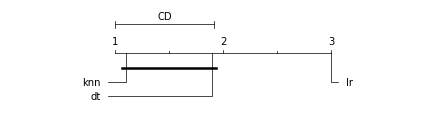

0.9178133315493953


In [23]:
import Orange
names = resultados.columns.values
avranks = ranking.mean() # calculando ranking medio de cada metodo (coluna)
cd = Orange.evaluation.compute_CD(avranks, len(ranking), alpha="0.1")
Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=6, textspace=1.5)
plt.show()
print(cd)